# Make Tilt Series Video
Create a video which shows the original and labeled images next to each other as the sample is tiled.

In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt
from matplotlib import colormaps
from matplotlib import animation
from rtdefects.drift import subtract_drift_from_images
from skimage.transform import resize
from pathlib import Path
from imageio import v3 as iio
import pandas as pd
import numpy as np

## Load then Align the Masks and Reference Images
Load them then use the drifts detected in the previous notebook to match everything up

In [2]:
frame_data = pd.read_json('frame-data.json', lines=True)

Load the image stack

In [3]:
labeled_with_drift = [
    np.transpose(iio.imread(p), axes=(1, 2, 0)) for p in frame_data['labeled_path']  # Put the label axis last
]

In [4]:
frames_with_drift = np.array([
    resize(iio.imread(p), output_shape=labeled_with_drift[0].shape[:2]) for p in frame_data['path']  # Make them the same size as labeled
])

Apply the drift correction

In [5]:
drifts = np.array(frame_data['drifts'].tolist())

In [6]:
frames = np.array(subtract_drift_from_images(frames_with_drift, drifts, expand_images=True, fill_value=1.))
print(f'New size of frames: {frames.shape}')

New size of frames: (10, 1098, 1081)


In [7]:
labeled_unmapped = subtract_drift_from_images(labeled_with_drift, drifts, expand_images=True)

In [8]:
labeled_unmapped[0].shape

(1098, 1081, 374)

## Make the ID of a Void Consistant
Map the void ID between each frame based on the particle tracking

In [9]:
track_data = pd.read_json('track-data.json', lines=True)

In [10]:
def consolidate_tracks(labeled_imgs: list[np.ndarray], track_data: pd.DataFrame) -> np.ndarray:
    """Produce a single stack of images where the masks belonging to each 
    tracked defect are collected together

    Args:
        labeled_images: A list of images of shape (num_defects_in_frame, *image_shape)
        track_data: Data produced by tracking
    Returns:
        A array where [f, d, i, j] corresponds to the type of defect "d" in frame "f"
        at position (i, j)
    """

    # TODO (wardlt): Use a sparse array
    output = np.zeros((len(frame_data), len(track_data)) + labeled_imgs[0].shape[:2], dtype=bool)

    # For each tracked void
    for d, row in track_data.iterrows():
        frame_id = np.arange(row['total_frames']) + row['start_frame']
        for f, li in zip(frame_id, row['local_id']):
            if li is not None:
                output[f, d, :, :] = labeled_imgs[f][:, :, li] > 0

    return output

In [11]:
labeled = consolidate_tracks(labeled_unmapped, track_data)
print(f'Made a composite image of all labels. Shape: {labeled.shape}')

Made a composite image of all labels. Shape: (10, 1110, 1098, 1081)


## Make the video
Start with a function to plot a single frame

Start with a function to produce a colormap for a frame

In [12]:
cmap = colormaps['nipy_spectral']
colors = np.linspace(0, 1, labeled.shape[1])
np.random.shuffle(colors)
colors = cmap(colors)

In [13]:
def labels_to_colors(labels, colors) -> np.ndarray:
    """Generate an array where each pixel is colored according to its label
    
    Args:
        label: Single frame from the labeled mask
        colors: Colors to use for each defect
    Returns:
        
    """
    # Make the output
    output = np.zeros((labels.shape[1], labels.shape[2], 4))
    
    # Set the color for each pixel
    for i, mask in enumerate(labels):
        color = colors[i]
        for i, j in zip(*np.where(mask)):
            output[i, j, :] = color
    return output

CPU times: user 6min 40s, sys: 40.1 s, total: 7min 20s
Wall time: 7min 29s


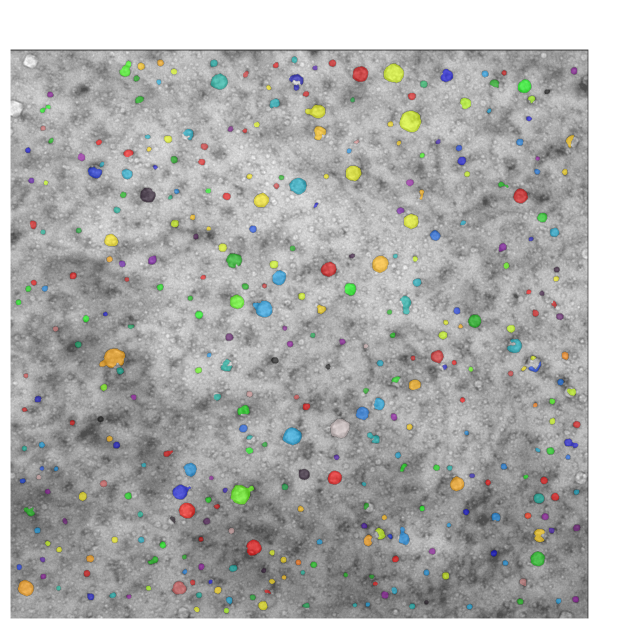

In [14]:
%%time
fig, ax = plt.subplots(figsize=(6.5, 6.5 * labeled.shape[-1] / labeled.shape[-2]))

ax.axison = False
im1 = ax.imshow(frames[0], cmap='gray', extent=[0, 1, 0, 1], vmin=0.1, vmax=1, alpha=0.7)
im2 = ax.imshow(labels_to_colors(labeled[0], colors), alpha=0.6, extent=[0, 1, 0, 1])

def plot_frame(i):
    sign = 1 if i // len(frame_data) % 2 else -1
    frame = i % len(frame_data)
    im1.set_data(frames[frame])
    im2.set_data(labels_to_colors(labeled[frame], colors))

fig.tight_layout()

ani = animation.FuncAnimation(fig, plot_frame, frames=len(frame_data) * 8, interval=10000 / len(frame_data), blit=False)
writer = animation.FFMpegWriter(fps=4, bitrate=16000)
ani.save("tilt-animation.mp4", writer=writer, dpi=320)